## Imports

In [91]:
import operator
import pickle
import random
import re
from collections import defaultdict, Counter
from itertools import count
from typing import List, Dict, Any, Tuple, Union, Optional, Callable

import matplotlib.pyplot as plt
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from langchain_text_splitters import RecursiveCharacterTextSplitter
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm

## Tokenizer

In [2]:
class WordTokenizer:
    def __init__(self):
        self.start_token = "[START]"
        self.end_token = "[END]"
        self.unk_token = "[UNK]"
        self.pad_token = "[PAD]"
        
        self.vocab = defaultdict(count().__next__)
        self.freq = defaultdict(int)

        self.__init_special_tokens__()

    def __init_special_tokens__(self):
        self.vocab[self.start_token]
        self.vocab[self.end_token]
        self.vocab[self.pad_token]
        self.vocab[self.unk_token]

    def insert_token(self, token):
        if token not in self.vocab:
            self.vocab[token]

    def train(self, samples: List[str]):

        for sample in tqdm(samples):
            sample_splitted = sample.split()
            for token in sample_splitted:
                self.insert_token(token)
            
        self.vocab_size = len(self.vocab)
        self.i2w = {v: k for k, v in self.vocab.items()}

    def encode(
        self, 
        input_text: Union[str, List],
        max_length: Optional[int] = None,
        preprocessing_function: Callable = lambda x: x,
        exclude_end_token: bool = False
    ) -> Union[List[int], List[List[int]]]:
        input_ids = []
        
        if type(input_text) == str:
            input_text = preprocessing_function(input_text)
            input_text_splitted = input_text.split()

            input_ids.append(self.vocab.get(self.start_token))
            for token in input_text_splitted:
                input_ids.append(self.vocab.get(token, self.vocab.get(self.unk_token)))
                if max_length is not None and max_length - 1 == len(input_ids):
                    break

            if not exclude_end_token:
                input_ids.append(self.vocab.get(self.end_token))

            if max_length is not None and len(input_ids) < max_length:
                input_ids.extend(
                    [self.vocab.get(self.pad_token) for _ in range(len(input_ids), max_length)]
                )

        else:
            input_text = list(map(lambda x: preprocessing_function(x), input_text))
            for each_input_text in input_text:
                each_input_ids = []
                each_input_text_splitted = each_input_text.split()
                for token in each_input_text_splitted:
                    each_input_ids.append(self.vocab.get(token, self.vocab.get(self.unk_token)))
                    if max_length is not None and max_length - 1 == len(each_input_ids):
                        break

                    if not exclude_end_token:
                        each_input_ids.append(self.vocab.get(self.end_token))
                        
                    if max_length is not None and len(each_input_ids) < max_length:
                        each_input_ids.extend(
                            [self.vocab.get(self.pad_token) for _ in range(len(each_input_ids), max_length)]
                        )
                input_ids.append(each_input_ids)

        return input_ids

    def decode(
        self, input_ids: Union[List[int], List[List[int]]]
    ) -> Union[str, List[str]]:
        decoded_string = []
        
        if type(input_ids) == list and type(input_ids[0]) == int:
            for id in input_ids:
                decoded_string.append(self.i2w.get(id))

        else:
            for each_input_id in input_ids:
                decoded_string_each = []
                for id in each_input_id:
                    decoded_string_each.append(self.i2w.get(id))
                decoded_string_each.append(decoded_string_each)

        return decoded_string

    def save(self, output_file="model/word.tokenizer"):
        with open(output_file, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(output_file="model/word.tokenizer"):
        with open(output_file, "rb") as f:
            tokenizer = pickle.load(f)
        return tokenizer

In [3]:
tokenizer = WordTokenizer.load("../emotion/model/word.tokenizer")

## Model

In [4]:
class RNNClassifier(nn.Module):
    def __init__(
        self, n_classes: int, vocab_size: int, num_layers, embedding_size: int, 
        embedding_dropout_rate: float, hidden_size: int, bidirectional
    ) -> None:
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding_dropout = nn.Dropout(embedding_dropout_rate)

        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            bidirectional=bidirectional,
            num_layers=num_layers,
            batch_first=True
        )

        self.classifier = nn.Linear(
            in_features=hidden_size*2 if bidirectional else hidden_size,
            out_features=n_classes
        )

        self.gelu = nn.GELU()

    def forward(self, token_ids):
        # token_ids: [B, max_seq_len]
        out = self.embedding_dropout(self.embedding(token_ids))
        # out: [B, max_seq_len, embed_dim]
        out, (hidden, cell) = self.lstm(out)
        # out: [B, max_seq_len, hidden_size]
        hidden, cell = None, None
        out = out[:, 0, :]
        # out: [B, hidden_size]
        out = self.gelu(out)
        return self.classifier(out)
        # return: [B, max_seq_len, vocab_size]

In [6]:
LABEL_ENCODER = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

model = RNNClassifier(len(LABEL_ENCODER), tokenizer.vocab_size, 1, 256, 0.1, 512, True)

In [7]:
model.load_state_dict(torch.load("../emotion/model/model_emotion.pt", weights_only=True))

/Users/safak.bilici/miniconda3/envs/default/lib/python3.11/site-packages/torch/_utils.py:832: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [85]:
embeddings = torch.Tensor(model.embedding.weight)

In [86]:
def get_embedding(w, embeddings, tokenizer, to_numpy=False):
    w_splitted = w.split()
    if len(w_splitted) == 1:
        w = w_splitted[0]
        input_id = tokenizer.encode(w)[1:-1][0]
        v_w = embeddings[input_id, :][None, :].detach()

    else:
        input_ids = tokenizer.encode(w)[1:-1]
        v_i_w = torch.stack([embeddings[input_id, :] for input_id in input_ids])
        v_w = v_i_w.mean(dim=0)[None, :].detach()

    return v_w.numpy() if to_numpy else v_w

In [106]:
selected_words = [
    "joy", "happy", "anger", "pissed", "sad", "crying", "fight", "fear", "love", "hate",
    "excited", "bored", "calm", "anxious", "relaxed", "tense", "hopeful", "hopeless",
    "curious", "confused", "grateful", "jealous", "content", "resentful", "disgusted",
    "surprised", "shocked", "lonely", "proud", "ashamed", "embarrassed", "frustrated",
    "elated", "miserable", "ecstatic", "melancholic", "guilty", "nostalgic", "worried",
    "apathetic", "insecure", "trusting", "doubtful", "optimistic", "pessimistic", "fearful",
    "envious", "regretful", "sorrowful", "amused", "peaceful"
]

selected_embeddings = torch.stack(
    [get_embedding(word, embeddings, tokenizer, False) for word in selected_words]
).squeeze(1).numpy()

In [ ]:
reducer = umap.UMAP(n_components=2) 
embedding_to_vis = reducer.fit_transform(selected_embeddings) 

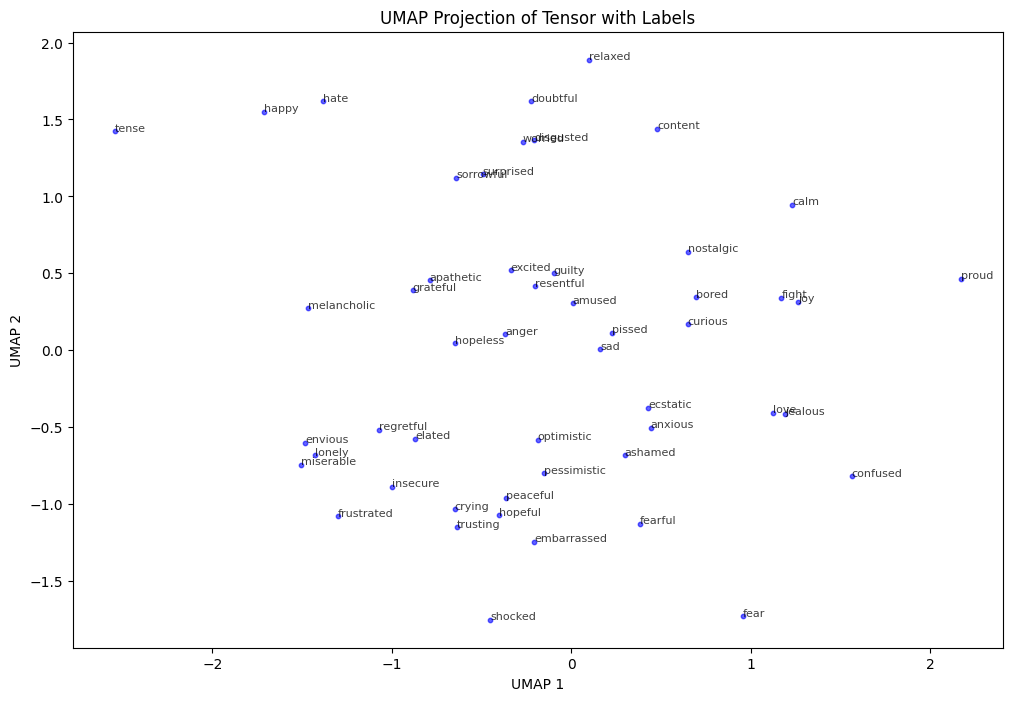

In [108]:
plt.figure(figsize=(12, 8))
plt.scatter(selected_embeddings[:, 0], selected_embeddings[:, 1], s=10, c='blue', alpha=0.6)

for i, label in enumerate(selected_words):
    plt.annotate(label, (selected_embeddings[i, 0], selected_embeddings[i, 1]), fontsize=8, alpha=0.75)

plt.title('UMAP Projection of Tensor with Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()